# Concentration Dependent Stress 

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results_model/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

In [4]:
cell = 4
sno = 9
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [5]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9,0]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09,0]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09,0]
# New Mech Damage Model
par_val[6]=[2.056E-07,2.4664E-06,1.2468,1.0482e-09,0]
# New Mech Damage Model with Lithium plating resistane
par_val[7]=[2.190e-07,2.308e-06,1.214,2.537e-09,0]
# New Assymetric Mech Damage Model
par_val[8]=[1.426128e-07,3.8319724e-06,1.215,2.35e-09,1.462e-06]
# New Assymetric Mech Damage Model, tuned using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging version 2
par_val[9] = [1.41036e-07,2.391e-06,1.2098,2.4487124e-09,7.33e-08]

In [6]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        # "Positive electrode LAM constant exponential term": 1,
        # "Negative electrode LAM constant exponential term": 1,
        "Negative electrode critical stress [Pa]": 60e6,
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Positive electrode reference exchange-current density activation energy [J.mol-1]": 0,
        "Positive electrode diffusion coefficient activation energy [J.mol-1]": 0,
        "Negative electrode reference exchange-current density activation energy [J.mol-1]": 0,
        "Negative electrode diffusion coefficient activation energy [J.mol-1]": 0,
        # "Positive electrode LAM constant proportional term 2 [s-1]": 0,
        # "Negative electrode LAM constant proportional term 2 [s-1]": par_val[sno][4],
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant proportional term 2 [s-1]": 0,
        "Negative electrode LAM constant proportional term 2 [s-1]": par_val[sno][4],
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]":0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
        "Negative electrode partial molar volume [m3.mol-1]":	1*7e-06,
    },
    check_already_exists=False,
)


In [7]:
# c_rate_d = '2C'
# c_rate_c = '1.5C'
c_rate_c ='C/5'
c_rate_d ='C/5'
# c_rate_c ='1.5C'
# c_rate_d ='1.5C'

In [8]:
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes", 
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
    period = "10 sec",
#     cccv_handling="ode",
)

experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 10 sec",
         "Discharge at "+c_rate_d+" until 3V",
        #  "Discharge at "+c_rate_d+" for 150 min",
         )
    ]*1,
    termination="50% capacity",
    period = "10 sec",
#     cccv_handling="ode",
)
SOC_0 =0.0

In [9]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution1 = sol_long

2023-07-10 15:48:47.133 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (12.788 ms elapsed) --------------------
2023-07-10 15:48:47.133 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/4: Charge at C/5 until 4.2V
2023-07-10 15:48:47.330 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/4: Hold at 4.2V until C/50
2023-07-10 15:48:47.442 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/4: Rest for 10 sec
2023-07-10 15:48:47.475 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/4: Discharge at C/5 until 3V
2023-07-10 15:48:48.037 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.851 Ah (originally 4.851 Ah, will stop at 2.426 Ah)
2023-07-10 15:48:48.038 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 916.419 ms


In [10]:
# c_rate_c ='2C'
c_rate_c ='1.5C'
c_rate_c ='C/5'
c_rate_d ='C/5'
# c_rate_c ='1.5C'
# c_rate_d ='1.5C'

experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
    period = "10 sec",
#     cccv_handling="ode",
)
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 10 sec",
        #  "Discharge at "+c_rate_d+" until 3V",
          "Discharge at "+c_rate_d+" for 150 min",
         )
    ]*1,
    termination="50% capacity",
    period = "10 sec",
#     cccv_handling="ode",
)
# drive_cycle = pd.read_csv(cyc_DIR+'peyman_drive_cycle_current'+'.csv', comment="#", header=None).to_numpy()
# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50",
#          "Rest for 5 min",
#          "Run DriveCycle (A)",
#         )
#     ] ,
#     drive_cycles={"DriveCycle": drive_cycle},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
parameter_values.update(
    {
        "Negative electrode partial molar volume [m3.mol-1]":	0.747*7e-06,
    },
    check_already_exists=False,
)
SOC_0 = 0.5

sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution2 = sol_long

2023-07-10 15:48:49.686 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (12.764 ms elapsed) --------------------
2023-07-10 15:48:49.687 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/4: Charge at C/5 until 4.2V
2023-07-10 15:48:49.818 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/4: Hold at 4.2V until C/50
2023-07-10 15:48:49.921 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/4: Rest for 10 sec
2023-07-10 15:48:49.960 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/4: Discharge at C/5 for 150 min
2023-07-10 15:48:50.326 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.851 Ah (originally 4.851 Ah, will stop at 2.426 Ah)
2023-07-10 15:48:50.327 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 652.437 ms


In [11]:
# sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe"))
# sol_long = sim_long.solve(initial_soc=SOC_0)
# solution1 = sol_long

In [12]:
def plot_vars(solution):
    t =  solution["Time [s]"].entries
    t = t/3600
    V =  solution["Terminal voltage [V]"].entries
    I =  solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries
    Q_Li = solution["Loss of capacity to lithium plating [A.h]"].entries
    I_Li = solution["X-averaged lithium plating interfacial current density [A.m-2]"].entries

    I_de = solution["X-averaged negative electrode interfacial current density [A.m-2]"].entries
    I_st = solution["X-averaged lithium plating interfacial current density"].entries
    I_to = solution["X-averaged negative electrode total interfacial current density [A.m-2]"].entries

    # phi_seif = solution["X-averaged SEI film overpotential [V]"].entries
    phi_seif = []
    # phi_sei  = solution["X-averaged negative electrode sei reaction overpotential [V]"].entries
    phi_sei  = []
    # phi_sei = 0
    phi_pl  = solution["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
    phi_pl_nd  = solution["X-averaged negative electrode lithium plating reaction overpotential"].entries
    phi_del = solution["X-averaged negative electrode surface potential difference [V]"].entries

    phi_ocp = solution["X-averaged negative electrode open circuit potential [V]"].entries
    phi_int = solution["X-averaged negative electrode reaction overpotential [V]"].entries

    i0_int = solution["X-averaged negative electrode exchange current density [A.m-2]"].entries
    phi_e_avg = solution["X-averaged negative electrolyte potential [V]"].entries
    c_e_avg = solution["X-averaged negative electrolyte concentration [mol.m-3]"].entries
    c_ss_n = solution["X-averaged negative particle surface concentration"].entries
    c_save_n1 = solution["R-averaged negative particle concentration"].entries
    c_save_n = c_save_n1[1,:]
    c_s_n = solution["X-averaged negative particle concentration"].entries

    u_css_n = solution["X-averaged negative electrode open circuit potential [V]"].entries

    # j_pl = solution["Negative electrode lithium plating interfacial current density [A.m-2]"].entries
    j_pl = []
    # eta_pl = solution["Negative electrode lithium plating reaction overpotential [V]"].entries
    eta_pl = []
    sigma_ts_n = solution["X-averaged negative particle surface tangential stress [Pa]"].entries
    sigma_rs_n = solution["X-averaged negative particle surface radial stress [Pa]"].entries
    sigma_hs_n = (sigma_rs_n+2*sigma_ts_n)/2
    sigma_ts_p = solution["X-averaged positive particle surface tangential stress [Pa]"].entries
    sigma_rs_p = solution["X-averaged positive particle surface radial stress [Pa]"].entries
    sigma_hs_p = (sigma_rs_p+2*sigma_ts_p)/2

    C_n = solution["Negative electrode capacity [A.h]"].entries
    C_p = solution["Positive electrode capacity [A.h]"].entries

    return t,V,I,Q,Q_Li,I_Li,I_de,I_st,I_to,phi_seif,phi_sei,phi_pl,phi_del,phi_ocp,phi_int,i0_int,phi_e_avg,c_e_avg,c_ss_n,c_save_n,c_s_n,u_css_n,j_pl,eta_pl,sigma_hs_n,C_n,sigma_hs_p,C_p

In [13]:
def graphite_volume_change(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    t_change = np.interp(x,stoichpoints,thicknesspoints)
    return t_change

In [14]:
# O_n/0.13*(13.0635/100)

In [15]:
(13.0635/100-5.583/100)/(1-0.50)

0.14961

In [16]:
(2.406/100)/(0.12)

0.2005

In [17]:
0.14961/0.2005

0.7461845386533665

In [18]:
# 4.55e-6*c_s_max_n

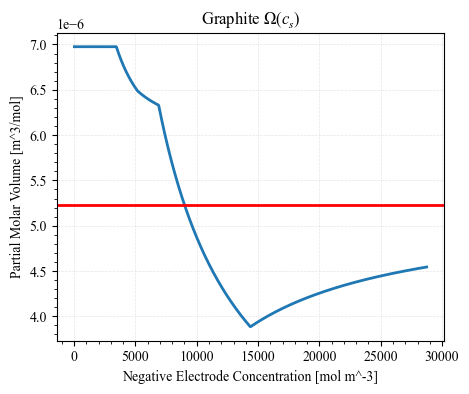

In [19]:
x = np.linspace(0,1,1000)
y = np.vectorize(graphite_volume_change)(x)
O_n = 3.1e-6
c_s_max_n = 28746.0
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(c_s_max_n*x,y/(c_s_max_n*x))
plt.axhline(y = 7e-6*0.747, color = 'r', linestyle = '-')
ax.set_xlabel("Negative Electrode Concentration [mol m^-3]")
ax.set_ylabel("Partial Molar Volume [m^3/mol]")
ax.set_title(r"Graphite $\Omega(c_s)$")
plt.savefig(fig_DIR+'conc_dep_stress_func'+'.png')

# Compare Stress, Plating C Rates

In [20]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1,phi_ocp1,phi_int1,i0_int1,phi_e_avg1,c_e_avg1,c_ss_n1,c_save_n1,c_s_n1,u_css_n1,j_pl1,eta_pl1,sigma_hs_n1,C_n1,sigma_hs_p1,C_p1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2,phi_ocp2,phi_int2,i0_int2,phi_e_avg2,c_e_avg2,c_ss_n2,c_save_n2,c_s_n2,u_css_n2,j_pl2,eta_pl2,sigma_hs_n2,C_n2,sigma_hs_p2,C_p2 = plot_vars(solution2)

In [21]:
parameter_values.search("critical")

Negative electrode critical stress [Pa]	60000000.0
Positive electrode critical stress [Pa]	375000000.0


In [22]:
O_n/0.13*c_s_max_n

0.6854815384615385

In [23]:
O_n/0.130635*c_s_max_n

0.6821495005167068

In [24]:
E_n = 15e9
nu_n = 0.2
O_n = 7e-6
c_s_max_n = 28746.0
CC = 2*E_n/(1-nu_n)/3*O_n/0.130635*c_s_max_n
Rn = 1e-5

In [25]:
Rvec = np.linspace(0,Rn,20)

In [26]:
def sigma_hfun(c_s1,c_save_n1):
    sigma_h = []
    sigma_h1 = []
    for nn in range(np.size(c_s1,1)):
        c_s = c_s1[:,nn]
        y_s = np.vectorize(graphite_volume_change)(c_s)
        y_s1 = np.vectorize(graphite_volume_change)(c_save_n1[nn])
        cube = Rvec[1:]**3-Rvec[:-1]**3
        muln = (y_s[1:]+y_s[:-1])/2
        sigma_h_s = CC*((1/Rn**3)*1/3*np.sum(cube*muln)-1/3*y_s[-1])
        sigma_h_s1 = CC*(1/3*y_s1-1/3*y_s[-1])[0]
        sigma_h.append(sigma_h_s)
        sigma_h1.append(sigma_h_s1)
    sigma_h = np.array(sigma_h)
    sigma_h1 = np.array(sigma_h1)
    return sigma_h,sigma_h1

In [27]:
beta_LAM = par_val[sno][1]
beta_LAM2 = par_val[sno][4]
m_LAM = par_val[sno][2]
stress_critical = 60000000

In [28]:
import copy

In [29]:
def C_n_lfun(sigma_h,t):
    # stress_h_surf1 = copy.deepcopy(sigma_h)
    # stress_h_surf2 = copy.deepcopy(sigma_h)
    stress_h_surf1 = 1*sigma_h
    stress_h_surf2 = 1*sigma_h
    stress_h_surf1 *= stress_h_surf1 > 0
    stress_h_surf2 *= stress_h_surf2 < 0
    j_stress_LAM = (-beta_LAM*(abs(stress_h_surf2) / stress_critical) ** m_LAM + beta_LAM2*(abs(stress_h_surf1) / stress_critical) ** m_LAM)
    act_loss1 = scipy.integrate.cumtrapz(j_stress_LAM,t*3600)
    act_loss1 = np.append(act_loss1,act_loss1[-1])
    C_n_loss = []
    for act_loss in act_loss1:
        C_n_loss_t = parameter_values.evaluate(act_loss*(param.n.L * param.n.prim.c_max * param.F* param.A_cc)/3600)
        C_n_loss.append(C_n_loss_t) 
    C_n_loss = np.array(C_n_loss)
    return C_n_loss

In [30]:
sigma_h1,sigma_h1_1 = sigma_hfun(c_s_n1,c_save_n1)
C_n_loss1 = C_n_lfun(sigma_h1,t1)
C_n_loss1_1 = C_n_lfun(sigma_h1_1,t1)

In [31]:
# fig,ax = plt.subplots(1,2,figsize=(8,5))
# ax1 = ax.flat[0]
# ax1.plot(t1,sigma_hs_n1,'k')
# ax1.plot(t1,sigma_h1,'b')
# ax1.plot(t1,sigma_h1_1,'b--')
# ax1.legend(["Normal","Conc Dependent","Simplified Conc Dep"])
# ax1.set_title("Stress profile")
# ax1.set_xlabel("Time [hr]")
# ax1.set_ylabel("Stress [MPa]")
# ax2 = ax.flat[1]
# ax2.plot(t1,C_n1-C_n1[0],'k')
# ax2.plot(t1,C_n_loss1,'b')
# ax2.plot(t1,C_n_loss1_1,'b--')
# ax2.set_title("Capacity Loss")
# ax2.set_xlabel("Time")
# ax2.set_ylabel("Capacity [Ah]")
# fig.suptitle("C/5 100% Negative Electrode")
# fig.tight_layout()
# # plt.savefig(fig_DIR+'conc_dep_stress_cap_C5_100'+'.png')

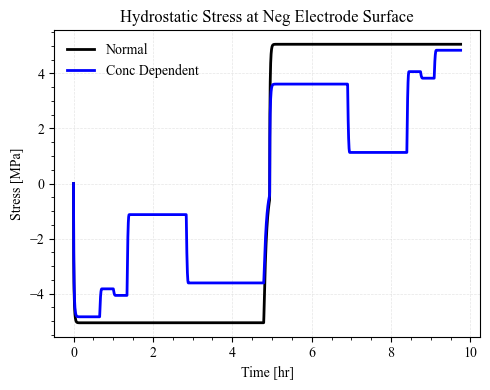

In [32]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(t1,sigma_hs_n1/1e6,'k')
ax1.plot(t1,sigma_h1/1e6,'b')
# ax1.plot(t1,sigma_h1_1,'b--')
ax1.legend(["Normal","Conc Dependent","Simplified Conc Dep"])
ax1.set_title("Hydrostatic Stress at Neg Electrode Surface")
ax1.set_xlabel("Time [hr]")
ax1.set_ylabel("Stress [MPa]")
fig.tight_layout()
# plt.savefig(fig_DIR+'conc_dep_stress_C5_50'+'.png')

In [33]:
# dfgdfgd

In [34]:
sigma_h2,sigma_h2_1 = sigma_hfun(c_s_n2,c_save_n2)
C_n_loss2 = C_n_lfun(sigma_h2,t2)
C_n_loss2_1 = C_n_lfun(sigma_h2_1,t2)

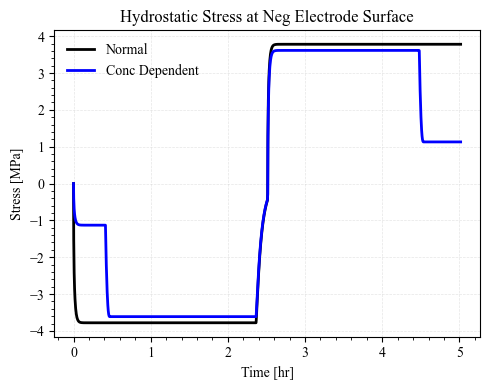

In [35]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(t2,sigma_hs_n2/1e6,'k')
ax1.plot(t2,sigma_h2/1e6,'b')
# ax1.plot(t1,sigma_h1_1,'b--')
ax1.legend(["Normal","Conc Dependent","Simplified Conc Dep"])
ax1.set_title("Hydrostatic Stress at Neg Electrode Surface")
ax1.set_xlabel("Time [hr]")
ax1.set_ylabel("Stress [MPa]")
fig.tight_layout()
# plt.savefig(fig_DIR+'conc_dep_stress_1p5C_50'+'.png')

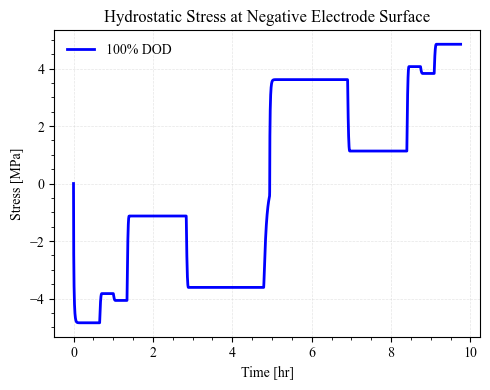

In [48]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(t1,sigma_h1/1e6,'b')
# ax1.plot(t2,sigma_h2/1e6,'g--')
# ax1.plot(t1,sigma_h1_1,'b--')
ax1.legend(["100% DOD","50% DOD"])
ax1.set_title("Hydrostatic Stress at Negative Electrode Surface")
ax1.set_xlabel("Time [hr]")
ax1.set_ylabel("Stress [MPa]")
fig.tight_layout()
plt.savefig(fig_DIR+'conc_dep_stress_C5_100'+'.png')

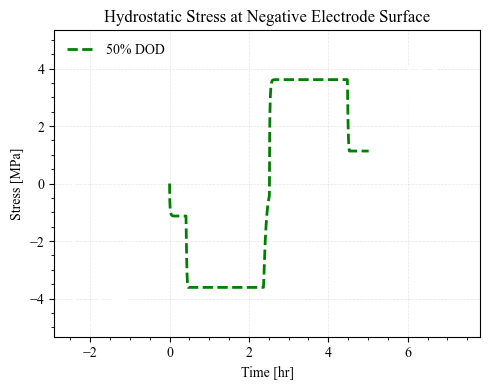

In [50]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(t1-2.42,sigma_h1/1e6,'w',label='_nolegend_')
ax1.plot(t2,sigma_h2/1e6,'g--')

# ax1.plot(t1,sigma_h1_1,'b--')
ax1.legend(["100% DOD","50% DOD"])
ax1.set_title("Hydrostatic Stress at Negative Electrode Surface")
ax1.set_xlabel("Time [hr]")
ax1.set_ylabel("Stress [MPa]")
ax1.legend(["50% DOD"])
fig.tight_layout()
plt.savefig(fig_DIR+'conc_dep_stress_C5_50'+'.png')

In [36]:
asdas

NameError: name 'asdas' is not defined

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,5))
ax1 = ax.flat[0]
ax1.plot(t2,sigma_hs_n2,'k')
ax1.plot(t2,sigma_h2,'b')
ax1.plot(t2,sigma_h2_1,'b--')
ax1.legend(["Normal","Conc Dependent"])
ax1.legend(["Normal","Conc Dependent","Simplified Conc Dep"])
ax1.set_title("Stress profile")
ax1.set_xlabel("Time [hr]")
ax1.set_ylabel("Stress [MPa]")
ax2 = ax.flat[1]
ax2.plot(t2,C_n2-C_n2[0],'k')
ax2.plot(t2,C_n_loss2,'b')
ax2.plot(t2,C_n_loss2_1,'b--')
ax2.set_title("Capacity Loss")
ax2.set_xlabel("Time")
ax2.set_ylabel("Capacity [Ah]")
fig.suptitle("c/5 50% Charge Negative Electrode")
fig.tight_layout()
# plt.savefig(fig_DIR+'conc_dep_stress_cap_C5_50'+'.png')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(t2,sigma_hs_n2/1e6,'k')
ax1.plot(t2,sigma_h2/1e6,'b')
# ax1.plot(t1,sigma_h1_1,'b--')
ax1.legend(["Normal","Conc Dependent","Simplified Conc Dep"])
ax1.set_title("Hydrostatic Stress at Neg Electrode Surface During 50% Charge")
ax1.set_xlabel("Time [hr]")
ax1.set_ylabel("Stress [MPa]")
fig.tight_layout()
# plt.savefig(fig_DIR+'conc_dep_stress_C5_50'+'.png')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(t1,sigma_h1/1e6,'b')
ax1.plot(t2,sigma_h2/1e6,'g--')
# ax1.plot(t1,sigma_h1_1,'b--')
ax1.legend(["100% DOD","50% DOD"])
ax1.set_title("Hydrostatic Stress at Negative Electrode Surface")
ax1.set_xlabel("Time [hr]")
ax1.set_ylabel("Stress [MPa]")
fig.tight_layout()
# plt.savefig(fig_DIR+'conc_dep_stress_C5_100_50'+'.png')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(t1,sigma_h1/1e6,'b')
ax1.plot(t1,0.97*sigma_hs_n1/1e6,'k--')
# ax1.plot(t1,sigma_h1_1,'b--')
ax1.legend(["Conc Dep","Min Stress"])
ax1.set_title("Hydrostatic Stress at Negative Electrode Surface")
ax1.set_xlabel("Time [hr]")
ax1.set_ylabel("Stress [MPa]")
fig.tight_layout()
plt.savefig(fig_DIR+'conc_dep_stress_1p5C'+'.png')

In [ ]:
print((C_n2[-1]-C_n2[0])/(C_n1[-1]-C_n1[0]))
print(C_n_loss2[-1]/C_n_loss1[-1])
print(C_n_loss2_1[-1]/C_n_loss1_1[-1])

In [ ]:
cvxcvxcv

In [ ]:
sigma_hs_n1_min = min(sigma_hs_n1/1e6)
sigma_hs_n2_min = min(sigma_hs_n2/1e6)
print(sigma_hs_n2_min/sigma_hs_n1_min)
print(max(C_n2[0]-C_n2)/max(C_n1[0]-C_n1))
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax1 = ax.flat[0]
ax1.plot(t1,sigma_hs_n1,'b--')
ax1.plot(t2,sigma_hs_n2,'r--')
ax1.set_title(r'$\sigma^-_{h,surf}$ [Pa]')
ax2 = ax.flat[1]
ax2.plot(t1,C_n1[0]-C_n1,'b--')
ax2.plot(t2,C_n2[0]-C_n2,'r--')
ax2.set_title(r'$C_{n,loss}$ [Ah]')
fig.tight_layout()
plt.show()
plt.savefig(fig_DIR+'negative_electrode_stress'+'.png')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax1 = ax.flat[0]
ax1.plot(t1,sigma_hs_p1,'b--')
ax1.plot(t2,sigma_hs_p2,'r--')
ax1.set_title(r'$\sigma^+_{h,surf}$ [Pa]')
ax2 = ax.flat[1]
ax2.plot(t1,C_p1[0]-C_p1,'b--')
ax2.plot(t2,C_p2[0]-C_p2,'r--')
ax2.set_title(r'$C_{p,loss}$ [Ah]')
fig.tight_layout()
plt.savefig(fig_DIR+'positive_electrode_stress'+'.png')

In [ ]:
sigma_hs_p1_min = min(sigma_hs_p1/1e6)
sigma_hs_p2_min = min(sigma_hs_p2/1e6)
print(sigma_hs_p1_min)
print(sigma_hs_p2_min)
print(sigma_hs_p2_min/sigma_hs_p1_min)

In [ ]:
aSAs

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
ax1 = axes.flat[0]
ax1.plot(t1,sigma_hs_n1,'b--')
ax1.plot(t2,sigma_hs_n2,'rv-')
ax1.set_title(r'$\sigma_{h,surf}$ [Pa]')
ax11 = axes.flat[1]
ax11.plot(t1,c_ss_n1-c_save_n1,'b--')
# ax11.plot(t1,c_save_n1,'b--')
ax11.plot(t2,c_ss_n2-c_save_n2,'rv-')
ax11.set_title(r'$c_{ss}^--c_{s,avg}^-$ [mol.$m^{-3}$]')
plt.savefig(fig_DIR+'mech_stress_crate'+'.png')

In [ ]:

fig, axes = plt.subplots(6, 2, figsize=(8, 10))
ax1 = axes.flat[0]
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'rv-')
ax1.set_title('Voltage [V]')
ax2 = axes.flat[2]
ax2.plot(t1,phi_ocp1,'b')
ax2.plot(t2,phi_ocp2,'rv-')
ax2.set_title(r'U($c_{ss})$  [V]')
ax3 = axes.flat[6]
ax3.plot(t1,phi_pl1,'b')
ax3.plot(t2,phi_pl2,'rv-')
ax3.axhline(y = 0.0, color = 'k', linestyle = '--')
ax3.set_title(r'$\eta_{pl}$ [V]')
ax4=axes.flat[3]
ax4.plot(t1,i0_int1,'b')
ax4.plot(t2,i0_int2,'rv-')
ax4.set_title(r'$i_0$  [A.$m^{-2}$]')
ax5=axes.flat[4]
ax5.plot(t1,phi_int1,'b')
ax5.plot(t2,phi_int2,'rv-')
ax5.set_title(r'$\eta_{int}$ [V]')
ax6=axes.flat[7]
ax6.plot(t1,I_Li1,'b')
ax6.plot(t2,I_Li2,'rv-')
ax6.set_title(r'$j_{pl}$ [A.$m^{-2}$]')
ax7 = axes.flat[1]
ax7.plot(t1,I1,'b')
ax7.plot(t2,I2,'rv-')
ax7.set_title('Current [A]')
ax8=axes.flat[5]
ax8.plot(t1,I_to1,'b')
ax8.plot(t2,I_to2,'rv-')
ax8.set_title(r'$j_{int}$  [A.$m^{-2}$]')
ax9=axes.flat[8]
ax9.plot(t1,phi_e_avg1,'b')
ax9.plot(t2,phi_e_avg2,'rv-')
ax9.set_title(r'$\overline{\Phi}^-_{e}$ [V]')
ax10=axes.flat[9]
ax10.plot(t1,c_e_avg1,'b')
ax10.plot(t2,c_e_avg2,'rv-')
ax10.set_title(r'$\overline{c}^-_{e}$ [mol.$m^{-3}$]')

ax11 = axes.flat[10]
ax11.plot(t1,c_ss_n1-c_save_n1,'b--')
# ax11.plot(t1,c_save_n1,'b--')
ax11.plot(t2,c_ss_n2-c_save_n2,'rv-')
# ax11.plot(t2,c_save_n2,'r--')
# ax11.legend(['surf','ave'])
ax11.set_title(r'$c_{ss}^--c_{s,avg}^-$ [mol.$m^{-3}$]')
ax12 = axes.flat[11]
ax12.plot(t1,Q_Li1,'b')
ax12.plot(t2,Q_Li2,'rv-')
ax12.set_title('Capacity lost due to plating [Ah]')

ax11.set_xlabel("Time [hr]")
ax12.set_xlabel("Time [hr]")
# ax5.set_ylim([-0.1,1])
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
# ax1.legend(['C/5','1.5C'])
ax1.legend(['1.5C','2C'])
axis = [ax1,ax2,ax5,ax3,ax9,ax7,ax4,ax8,ax6,ax10,ax11,ax12]
labels = ["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)","l)"]
for ax, label in zip(axis,labels):
  ax.text(-0.1,1.1,label,transform=ax.transAxes, fontsize=14)  

# ax1.legend(['SPM','SPMe'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_models_1p5C'+'.png')
plt.savefig(fig_DIR+'plating_compare_crate_new_2'+'.png')

In [ ]:
i_pl_area1 = np.trapz(I_Li1,t1)
i_pl_avg1 = i_pl_area1/t1[-1]
i_pl_area2 = np.trapz(I_Li2,t2)
i_pl_avg2 = i_pl_area2/t2[-1]
print(i_pl_avg1)
print(i_pl_avg2)
print(i_pl_avg2/i_pl_avg1)
print(Q_Li2[-1]/Q_Li1[-1])

In [ ]:
fgdfgd

In [ ]:
len(c_s_n1[:,0])

# Concentration Evolution

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],c_ss_n1,'b')
ax.plot(t1/t1[-1],c_save_n1,'b--')
ax.plot(t1/t1[-1],c_s_n1[0,:],'b-.')
ax.plot(t2/t2[-1],c_ss_n2,'r')
ax.plot(t2/t2[-1],c_save_n2,'r--')
ax.plot(t2/t2[-1],c_s_n2[0,:],'r-.')
ax.legend([r"C/5 $c_{ss}$",r"C/5 $c_{s,ave}$",r"C/5 $c_{s,0}$",r"1.5C $c_{ss}$",r"1.5C $c_{s,ave}$",r"1.5C $c_{s,0}$"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Conc [mol$m^{-3}$]")
ax.set_title(r'Negative Electrode Li Concentration $c_s$')
fig.savefig(fig_DIR+"neg_conc_crate_comp_norm"+".png")